In [1]:
!pip install itables
!pip install pingouin
!pip install scikit-posthocs

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import pandas as pd
import numpy as np
import scipy.stats 
from scipy.stats import shapiro
import pingouin as pg
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp 
from statistics import median
from statistics import mean 
from statistics import stdev
from statistics import pstdev

In [12]:
%run '/Users/Study/Desktop/BIO project/Lab project - code /pickleContigs.ipynb'

In [19]:
def main(*folders_paths,sample_size,normalize=True):
  global NUM_OF_CONTIGS #change to contigs
  global NORMALIZE
  NUM_OF_CONTIGS=sample_size
  NORMALIZE = normalize
  if NORMALIZE: print("structure counts are normalized by length"\
                      ", and expressed as a ratio per 1000 bases.")  
  viral_classes_names=[]
  df_list=[]

  for folder_path in folders_paths:
    virus_type=os.path.basename(folder_path)
    viral_classes_names.append(virus_type)
    df_list.append(createDf(folder_path))
  
  stacked_df = pd.concat([df.assign(viral_class = viral_class) for df, viral_class in zip(df_list, viral_classes_names)])
  stacked_df= stacked_df.reindex(['viral_class','name','length','free_energy','unpaired_ratio','stems','multiloops','hairpins','interior_loops'], axis=1)
  display(stacked_df)


  ###statistical analysis###


  statistical_analysis(stacked_df,'unpaired_ratio') 
  kde_plot(stacked_df,'unpaired_ratio')
  box_plot(stacked_df,'unpaired_ratio')
  posthoc_dunn(stacked_df,'unpaired_ratio')
  
  statistical_analysis(stacked_df,'free_energy')
  kde_plot(stacked_df,'free_energy')
  box_plot(stacked_df,'free_energy')
  posthoc_dunn(stacked_df,'free_energy')
    
  statistical_analysis(stacked_df,'multiloops')
  kde_plot(stacked_df,'multiloops')
  box_plot(stacked_df,'multiloops')
  posthoc_dunn(stacked_df,'multiloops')

  statistical_analysis(stacked_df,'stems')
  kde_plot(stacked_df,'stems')
  box_plot(stacked_df,'stems')
  posthoc_dunn(stacked_df,'stems')
    
  statistical_analysis(stacked_df,'hairpins')
  kde_plot(stacked_df,'hairpins')
  box_plot(stacked_df,'hairpins')
  posthoc_dunn(stacked_df,'hairpins')

  statistical_analysis(stacked_df,'interior_loops')
  kde_plot(stacked_df,'interior_loops')
  box_plot(stacked_df,'interior_loops')
  posthoc_dunn(stacked_df,'interior_loops')
  



 
def createDf(folder_path):
  folder = os.listdir(folder_path)
  df = pd.DataFrame()
  i = 0
  for file_path in folder:
    if(i==NUM_OF_CONTIGS): break
    data=getData(folder_path +"/"+file_path)
    df = df.append([data],ignore_index = True)
    i+=1
  return df


def getData(file_path):
  with open(file_path, 'rb') as handle:
    contig = pickle.load(handle)
  data_dict = vars(contig)
  del data_dict['bg']
  length=data_dict['length']
  #values are nomralized by length if NORMALIZE == True
  if (NORMALIZE == True):
     data_dict['stems']= normalize_by_length(data_dict['stems'],length) 
     data_dict['hairpins']= normalize_by_length(data_dict['hairpins'],length) 
     data_dict['interior_loops']= normalize_by_length(data_dict['interior_loops'],length) 
     data_dict['multiloops'] = normalize_by_length(data_dict['multiloops'],length) 
     data_dict['free_energy'] = normalize_by_length(data_dict['free_energy'],length) 
  round_features(data_dict)
  return data_dict



def normalize_by_length(x,length):
  N=1000
  return (x/length)*N



def round_features(data_dict):
    for feature in data_dict:
        if feature != 'name':
            data_dict[feature]=round(data_dict[feature],3)

            
            
#### statitical testing ####



#returns list of lists, every list stores values of a feature for a specic viral_class

def create_list_of_list_of_var(stacked_df,variable):
  lst_of_samples=[]
  tmp=stacked_df.groupby('viral_class')[variable].apply(list).reset_index(name=variable)
  for index, row in tmp.iterrows():
    lst_of_samples.append(tmp.iat[index,1])
  return lst_of_samples




def statistical_analysis(stacked_df,variable,Negative=False):

  print('\nVariable = ',variable)
  normally_distributed = all_samples_are_noramlly_distributed(stacked_df,variable)
  if(normally_distributed!= True):
    print("not all samples are normally distributed")
    
  samples_lst=create_list_of_list_of_var(stacked_df,variable)
  equal_var_test_res=test_variances(*samples_lst,normally_distributed = normally_distributed)
    
  if(normally_distributed!= True): 
    test_means_non_normally_distributed(*samples_lst)
  else:
    test_means_normally_distributed(*samples_lst,df=stacked_df,variable=variable,variances_are_equal=equal_var_test_res)
  
 
    
def kde_plot(stacked_df,variable):

  tmp_dict = {}
  tmp =stacked_df.groupby('viral_class')[variable].apply(list).reset_index(name=variable)
  for index, row in tmp.iterrows():
    tmp_dict[tmp.iat[index,0]]=tmp.iat[index,1]
    
  print('\n')
  for viral_class, values in tmp_dict.items():
    print(viral_class,' median is', median(values))
    print(viral_class, 'mean is' , mean(values))
    print(viral_class, 'var is' , np.var(values,ddof=1))
    print('\n')    
    
  plt1=sns.kdeplot(data=tmp_dict, shade=True, bw=0.3).set(title=variable)
  plt.show()

    
    
    
def box_plot(stacked_df,variable):

  stacked_df.boxplot(by = 'viral_class', column=[variable], patch_artist=True, boxprops=dict(facecolor='paleturquoise'), grid = False)
  plt.show()



def all_samples_are_noramlly_distributed(stacked_df,variable):
  lst_of_samples = create_list_of_list_of_var(stacked_df,variable)
  for i in range(len(lst_of_samples)):
        if test_normality(lst_of_samples[i]) == False:
            return False  
  return True



#test given samples if normally distributed using the Shapiro–Wilk test
#H0: samples are normally distributed 


def test_normality(sample):
  alpha=0.05
  statistic, p_val = scipy.stats.shapiro(sample)
# statistic, p_val = scipy.stats.kstest(sample, scipy.stats.norm.cdf)
  rejected=(p_val<=alpha)    ## if (reject==true) then samples aren't normally distrubuted 
  #print('p_val=',p_val)
  return not rejected      #if H0 wasn't rejected we expect TRUE as a return value 


def test_normality_anderson(sample):

  res = scipy.stats.anderson(sample)
  statistic = res.statistic 
  critical_val = res.critical_values[2]
  rejected=(critical_val<=statistic)    ## if (reject==true) then samples aren't normally distrubuted 
  #print('p_val=',p_val)
  return not rejected      #if H0 wasn't rejected we expect TRUE as a return value 




#if variances are equal: apply ONE WAY ANOVA
#else: apply Welch’s ANOVA
#H0:means are equal 
#H1:means aren't equal

def test_means_normally_distributed(*samples,df,variable,variances_are_equal):
  alpha=0.05
  if variances_are_equal:       #fix this 
    print("\nOne way ANOVA test: testing if samples have the same means")
    statistic, p_val= scipy.stats.f_oneway(*samples)
  else:
    print("\nWelch’s ANOVA test: testing if samples have the same means")
    welch_df=pg.welch_anova(df,dv=variable,between='viral_class')
    statistic, p_val= welch_df.iat[0,3],welch_df.iat[0,4]

  print("H0: means are equal\nH1: means aren't equal")
  print("statistic = ",statistic,"p_val=",p_val)
  rejected=(p_val<=alpha)    ## if (reject==true) then means aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')

  return not rejected    #if H0 wasn't rejected we expect TRUE as a return value

def test_means_non_normally_distributed(*samples):
    
  alpha=0.05
  print("\nKruskal Walllis test: testing if samples have the same median")
  print("H0: medians are equal\nH1: medians aren't equal")

  statistic, p_val= scipy.stats.kruskal(*samples)
  print("statistic = ",statistic,"p_val=",p_val)

  rejected=(p_val<=alpha)    ## if (reject==true) then means aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')

    

##Barllet's/Levene's test 
##pre: given samples are normally distributed 
##H0: varainces are equal 
##H1: variances aren't equal 

def test_variances(*samples,normally_distributed):
  alpha=0.05

  if normally_distributed == True:
        statistic, p_val = scipy.stats.bartlett(*samples)
        print("\nBartlett's test: testing if samples are from populations with equal variances")

  else:
        print("\nLevene's test: testing if samples are from populations with equal variances")
        statistic, p_val = scipy.stats.levene(*samples)
        
  print("H0: varainces are equal\nH1: variances aren't equal")

  print("statistic = ",statistic,"p_val=",p_val)
  rejected=(p_val<=alpha)    ## if (reject==true) then variances aren't equal
  if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
  else: print('P_val is greater than alpha=0.05, failed to reject H0 ')
  return not rejected    #if H0 wasn't rejected we expect TRUE as a return value


#Kruskal-Wallis post hoc test
#determines exactly which groups are different 

def posthoc_dunn(stacked_df,variable):
    
  tmp_dict = {}
  tmp =stacked_df.groupby('viral_class')[variable].apply(list).reset_index(name=variable)

  for index, row in tmp.iterrows():
    tmp_dict[tmp.iat[index,0]]=tmp.iat[index,1]  
  # Convert dictionary to DataFrame
  data=pd.DataFrame([(k, val) for k, vals in tmp_dict.items() for val in vals], columns=['viral_class', variable])

  posthoc_test_res=sp.posthoc_dunn(data,val_col=variable, group_col='viral_class',p_adjust = 'bonferroni')
  print(variable)
  display(posthoc_test_res)
  return posthoc_test_res
    
    
  

In [20]:
mymona_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/mymonaviridae'
cysto_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/cystoviridae'
levi_path = '/Users/Study/Desktop/BIO project/Data/Pickled/pickled/leviviridae'

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,free_energy,unpaired_ratio,stems,multiloops,hairpins,interior_loops
0,leviviridae,ND_003028,3911,-493.365,30.350,74.406,7.926,25.313,41.166
1,leviviridae,ND_000659,3359,-513.001,29.801,77.106,9.824,20.542,46.740
2,leviviridae,ND_003225,3933,-524.645,30.587,79.329,7.119,19.069,53.140
3,leviviridae,ND_003641,3864,-531.607,29.762,75.828,6.729,18.116,50.983
4,leviviridae,ND_000666,3217,-461.309,34.038,76.158,8.393,21.759,46.006
...,...,...,...,...,...,...,...,...,...
68,mymonaviridae,ND_245944,9186,-385.005,37.666,76.965,8.165,20.901,47.899
69,mymonaviridae,ND_020828,7863,-339.259,36.920,73.763,7.885,19.458,46.420
70,mymonaviridae,ND_031708,10028,-376.030,37.016,71.899,7.679,18.548,45.672
71,mymonaviridae,ND_094774,8009,-406.864,35.972,77.912,7.991,18.729,51.192



Variable =  unpaired_ratio
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  3.181456102418523 p_val= 0.04347814222987152
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  91.6061914241722 p_val= 1.2822369217675319e-20
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 34.503
cystoviridae mean is 34.29172602739726
cystoviridae var is 2.5608838127853883


leviviridae  median is 30.587
leviviridae mean is 30.61846575342466
leviviridae var is 9.123055196727549


mymonaviridae  median is 34.948
mymonaviridae mean is 34.77068493150685
mymonaviridae var is 10.75851688546423




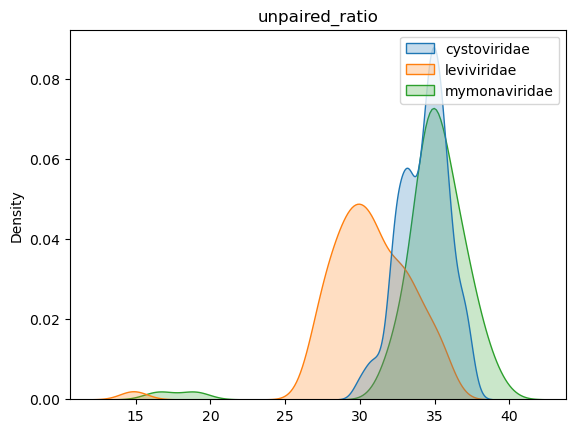

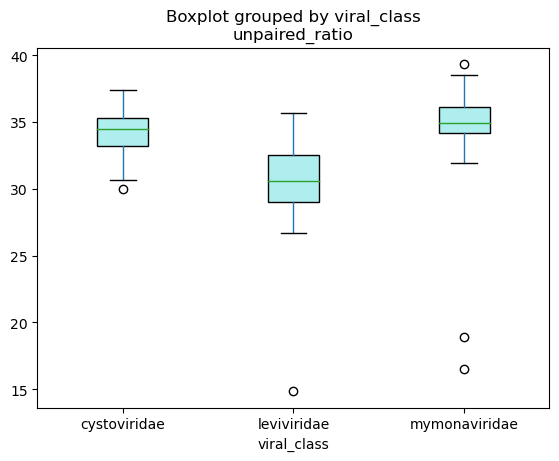

unpaired_ratio


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000e+00,2.659778e-12,1.572926e-01
leviviridae,2.659778e-12,1.000000e+00,3.064569e-19
mymonaviridae,1.572926e-01,3.064569e-19,1.000000e+00



Variable =  free_energy
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.21470114249496672 p_val= 0.8069544831732328
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  92.81853167306654 p_val= 6.993779536512109e-21
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is -407.012
cystoviridae mean is -419.0498904109589
cystoviridae var is 2513.6710471822685


leviviridae  median is -499.339
leviviridae mean is -491.4277397260274
leviviridae var is 2261.224399500761


mymonaviridae  median is -406.864
mymonaviridae mean is -401.4913424657534
mymonaviridae var is 2292.5665259783104




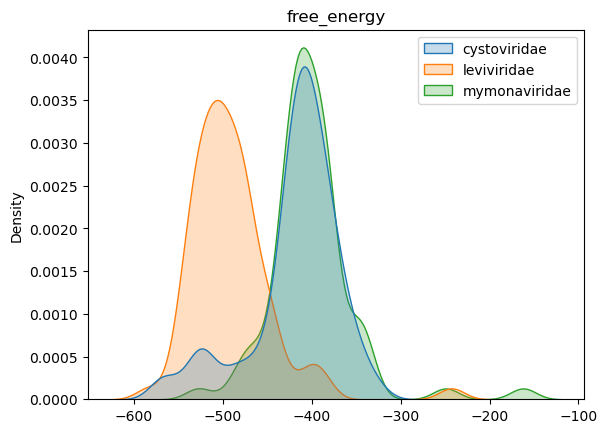

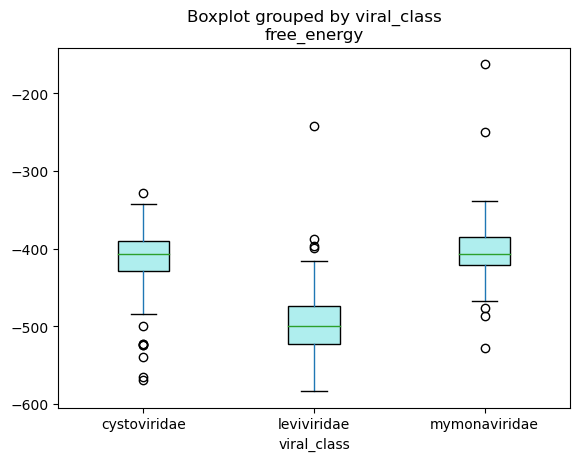

free_energy


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000e+00,7.618163e-14,5.852732e-01
leviviridae,7.618163e-14,1.000000e+00,1.456455e-18
mymonaviridae,5.852732e-01,1.456455e-18,1.000000e+00



Variable =  multiloops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  5.415073763195208 p_val= 0.005073660442089908
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  42.190533390429486 p_val= 6.893536508735614e-10
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 7.713
cystoviridae mean is 7.681589041095891
cystoviridae var is 0.26837616210045656


leviviridae  median is 7.225
leviviridae mean is 7.2110958904109586
leviviridae var is 0.9874455601217655


mymonaviridae  median is 8.065
mymonaviridae mean is 7.9913698630136984
mymonaviridae var is 0.6987186807458144




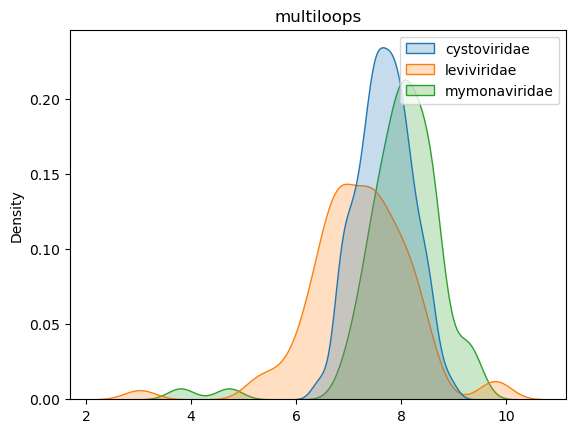

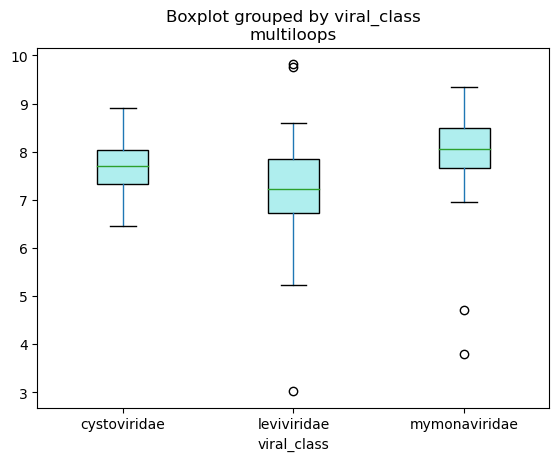

multiloops


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000,5.253973e-03,2.300031e-03
leviviridae,0.005254,1.000000e+00,2.507508e-10
mymonaviridae,0.002300,2.507508e-10,1.000000e+00



Variable =  stems
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.9305550371171176 p_val= 0.395909761059129
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  7.101950754370823 p_val= 0.028696635955366145
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 75.745
cystoviridae mean is 76.06506849315069
cystoviridae var is 6.22218873135464


leviviridae  median is 76.923
leviviridae mean is 76.66110958904109
leviviridae var is 26.098025015601216


mymonaviridae  median is 76.923
mymonaviridae mean is 75.94776712328768
mymonaviridae var is 47.17516126445965




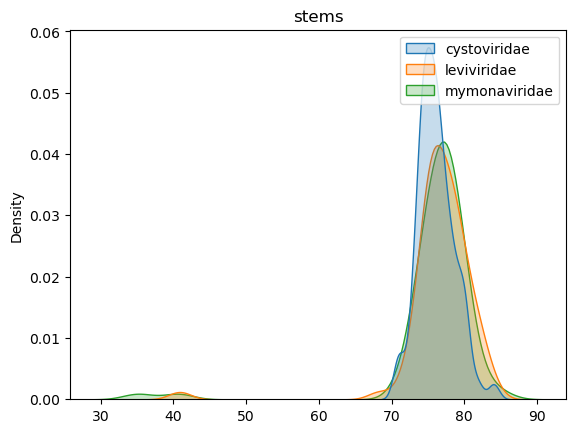

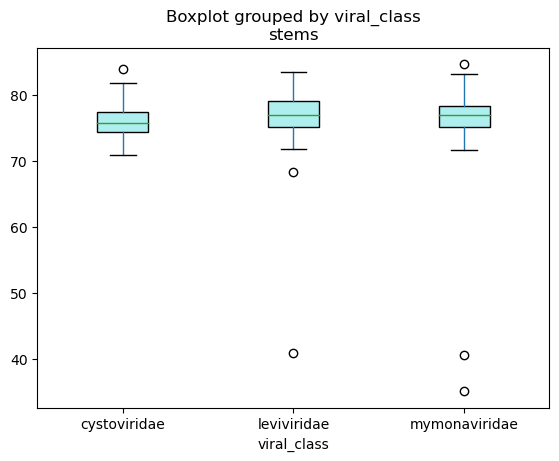

stems


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000,0.039742,0.109912
leviviridae,0.039742,1.000000,1.000000
mymonaviridae,0.109912,1.000000,1.000000



Variable =  hairpins
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  9.402538837565269 p_val= 0.00012150574632596079
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  47.4998087751399 p_val= 4.847832197129016e-11
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 20.862
cystoviridae mean is 20.74868493150685
cystoviridae var is 1.2114275521308977


leviviridae  median is 20.489
leviviridae mean is 20.548561643835615
leviviridae var is 6.609571527397261


mymonaviridae  median is 19.007
mymonaviridae mean is 18.964657534246577
mymonaviridae var is 3.5208083394216136




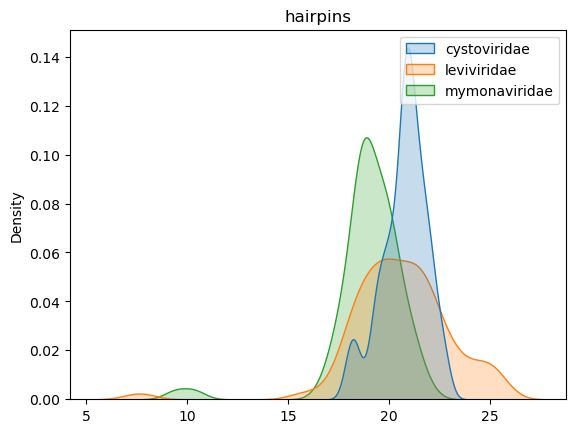

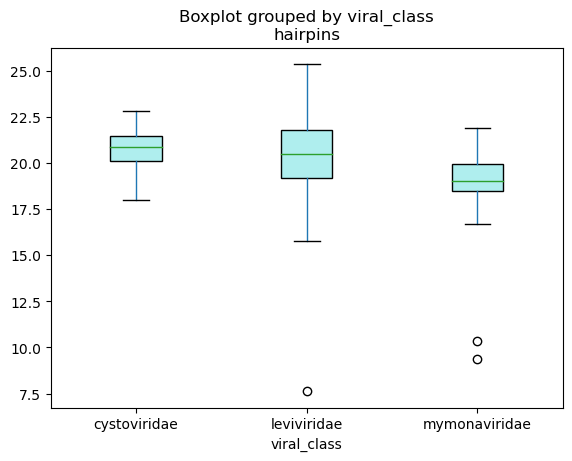

hairpins


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000e+00,6.339528e-01,2.496810e-10
leviviridae,6.339528e-01,1.000000e+00,4.696135e-07
mymonaviridae,2.496810e-10,4.696135e-07,1.000000e+00



Variable =  interior_loops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  3.5993232037024985 p_val= 0.02899459346150824
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  14.506818365696871 p_val= 0.0007077573968215431
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 47.303
cystoviridae mean is 47.634726027397264
cystoviridae var is 8.558547868340943


leviviridae  median is 49.041
leviviridae mean is 48.90131506849315
leviviridae var is 23.926498913242007


mymonaviridae  median is 49.623
mymonaviridae mean is 48.99176712328767
mymonaviridae var is 25.875852375570776




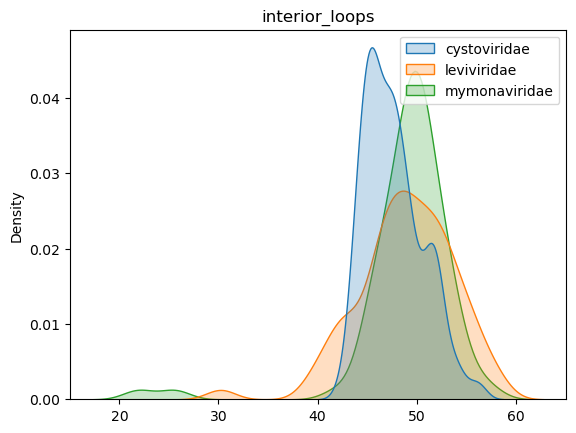

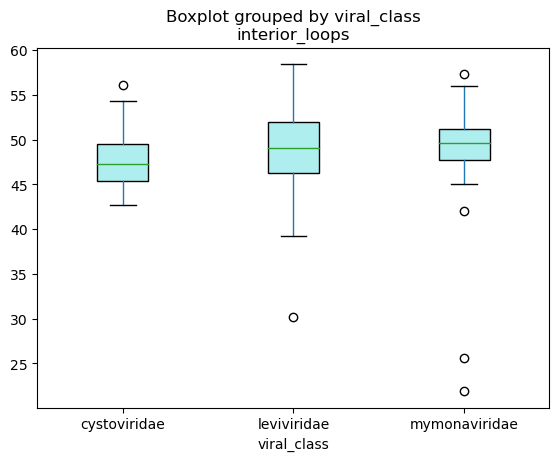

interior_loops


,cystoviridae,leviviridae,mymonaviridae
cystoviridae,1.000000,0.015851,0.000815
leviviridae,0.015851,1.000000,1.000000
mymonaviridae,0.000815,1.000000,1.000000


In [21]:
main(levi_path,cysto_path,mymona_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,free_energy,unpaired_ratio,stems,multiloops,hairpins,interior_loops
0,cystoviridae,ND_192340,9063,-428.156,34.503,77.127,7.172,21.075,48.880
1,cystoviridae,ND_301703,7116,-382.656,36.144,75.745,7.448,19.533,48.763
2,cystoviridae,ND_301536,7108,-423.920,34.553,79.910,7.316,18.289,54.305
3,cystoviridae,ND_015771,7051,-481.825,31.953,77.294,7.091,21.557,48.646
4,cystoviridae,ND_301508,7094,-409.491,34.846,78.658,7.330,19.876,51.452
...,...,...,...,...,...,...,...,...,...
68,mymonaviridae,ND_245944,9186,-385.005,37.666,76.965,8.165,20.901,47.899
69,mymonaviridae,ND_020828,7863,-339.259,36.920,73.763,7.885,19.458,46.420
70,mymonaviridae,ND_031708,10028,-376.030,37.016,71.899,7.679,18.548,45.672
71,mymonaviridae,ND_094774,8009,-406.864,35.972,77.912,7.991,18.729,51.192



Variable =  unpaired_ratio
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.2640929326631967 p_val= 0.2627484728992875
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  6.582111846637087 p_val= 0.010300860942001559
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 34.503
cystoviridae mean is 34.29172602739726
cystoviridae std is 1.6002761676615032


mymonaviridae  median is 34.948
mymonaviridae mean is 34.77068493150685
mymonaviridae std is 3.280017817857737




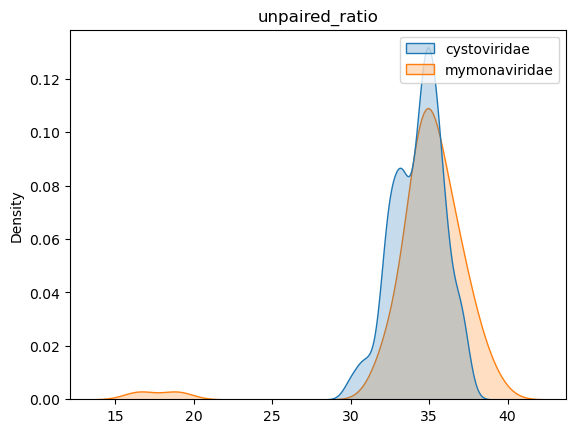

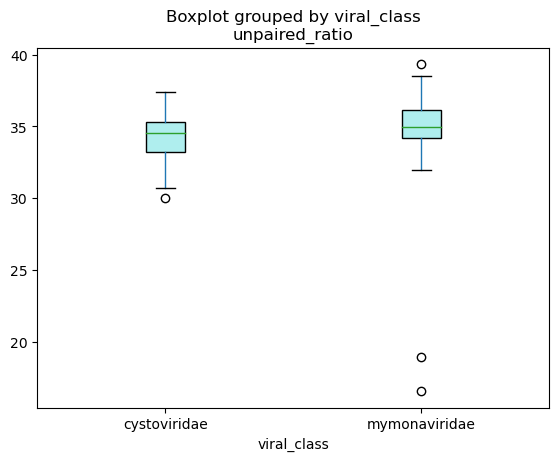

unpaired_ratio


,cystoviridae,mymonaviridae
cystoviridae,1.000000,0.010301
mymonaviridae,0.010301,1.000000



Variable =  free_energy
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.412876143563453 p_val= 0.5215350169048873
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  1.3649215772282173 p_val= 0.24268634705876702
P_val is greater than alpha=0.05, failed to reject H0 


cystoviridae  median is -407.012
cystoviridae mean is -419.0498904109589
cystoviridae std is 50.136524083568744


mymonaviridae  median is -406.864
mymonaviridae mean is -401.4913424657534
mymonaviridae std is 47.8807531893381




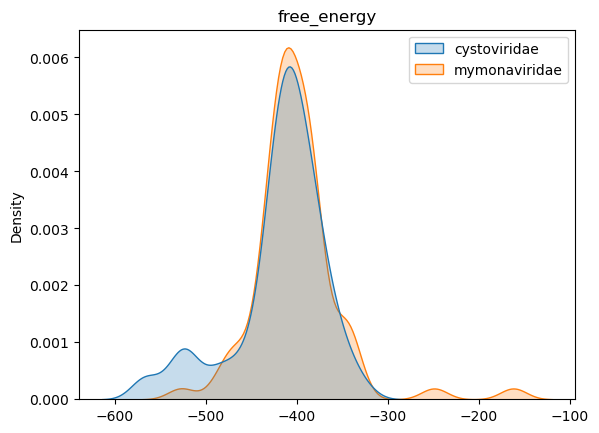

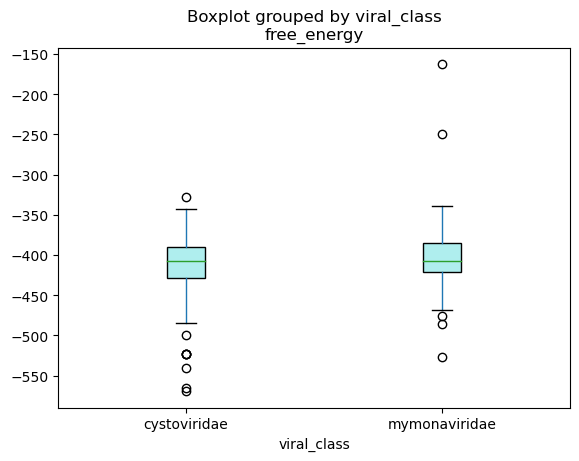

free_energy


,cystoviridae,mymonaviridae
cystoviridae,1.000000,0.242686
mymonaviridae,0.242686,1.000000



Variable =  multiloops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.6378527505240563 p_val= 0.2026783518985918
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  14.968383022531734 p_val= 0.00010932770892575594
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 7.713
cystoviridae mean is 7.681589041095891
cystoviridae std is 0.5180503470710706


mymonaviridae  median is 8.065
mymonaviridae mean is 7.9913698630136984
mymonaviridae std is 0.8358939410869146




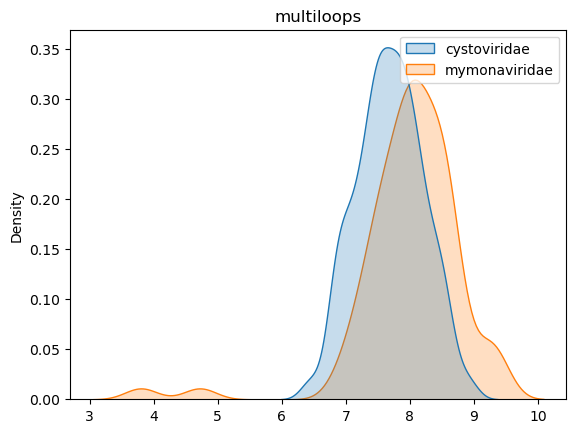

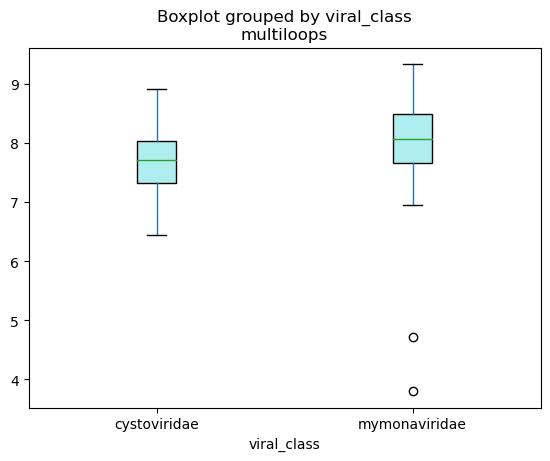

multiloops


,cystoviridae,mymonaviridae
cystoviridae,1.000000,0.000109
mymonaviridae,0.000109,1.000000



Variable =  stems
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.5237866116159857 p_val= 0.2190580088636603
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  4.752579810425491 p_val= 0.0292544047010332
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 75.745
cystoviridae mean is 76.06506849315069
cystoviridae std is 2.4944315447321137


mymonaviridae  median is 76.923
mymonaviridae mean is 75.94776712328768
mymonaviridae std is 6.868417668172173




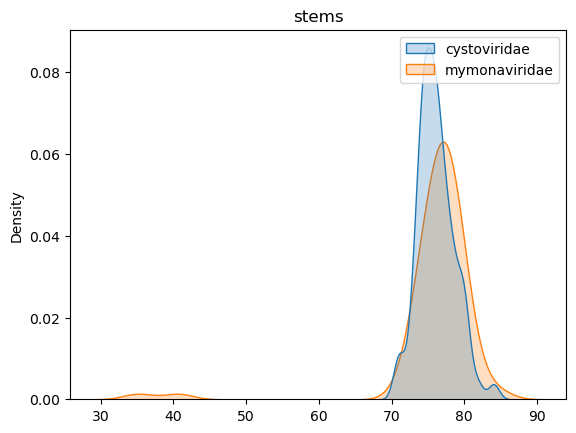

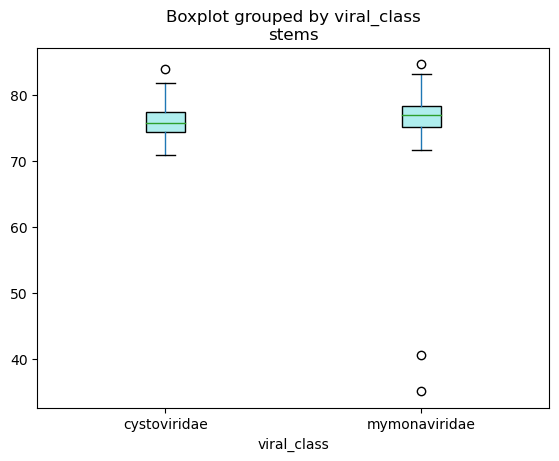

stems


,cystoviridae,mymonaviridae
cystoviridae,1.000000,0.029254
mymonaviridae,0.029254,1.000000



Variable =  hairpins
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  1.962278874894857 p_val= 0.1634210651045347
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  49.219423179292335 p_val= 2.288732308079734e-12
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 20.862
cystoviridae mean is 20.74868493150685
cystoviridae std is 1.1006486960565107


mymonaviridae  median is 19.007
mymonaviridae mean is 18.964657534246577
mymonaviridae std is 1.8763817147429287




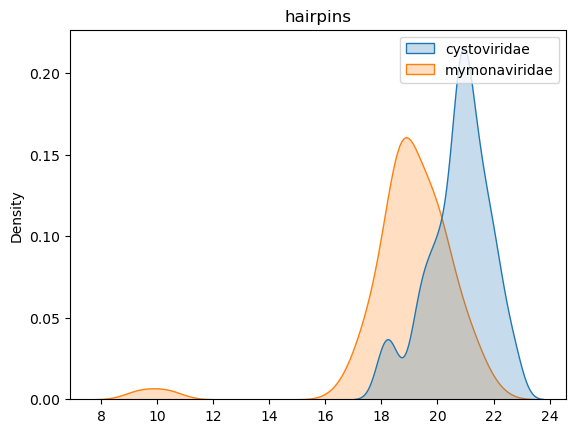

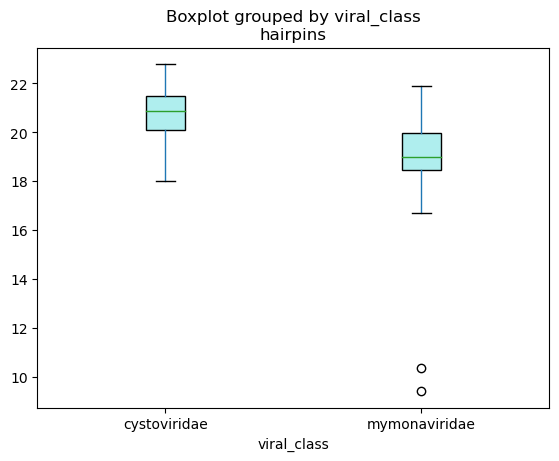

hairpins


,cystoviridae,mymonaviridae
cystoviridae,1.000000e+00,2.288732e-12
mymonaviridae,2.288732e-12,1.000000e+00



Variable =  interior_loops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.6247323429422752 p_val= 0.4305938761145722
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  15.797124704638861 p_val= 7.050957870847728e-05
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 47.303
cystoviridae mean is 47.634726027397264
cystoviridae std is 2.9254995929483467


mymonaviridae  median is 49.623
mymonaviridae mean is 48.99176712328767
mymonaviridae std is 5.086831270601648




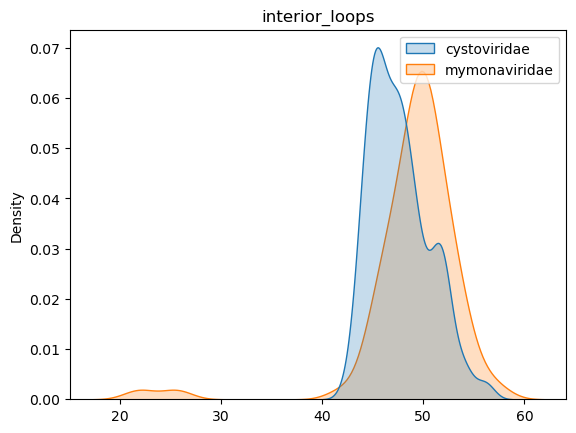

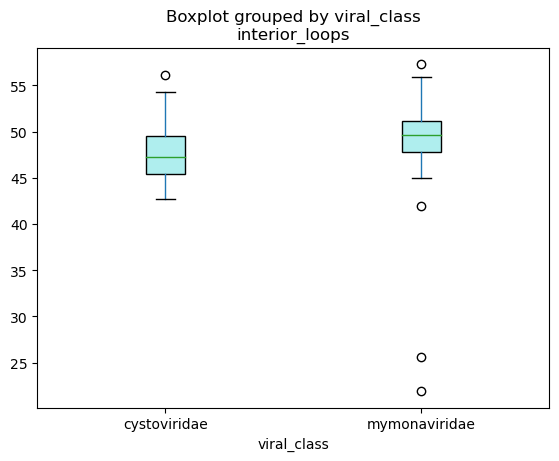

interior_loops


,cystoviridae,mymonaviridae
cystoviridae,1.000000,0.000071
mymonaviridae,0.000071,1.000000


In [7]:
main(cysto_path,mymona_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,free_energy,unpaired_ratio,stems,multiloops,hairpins,interior_loops
0,cystoviridae,ND_192340,9063,-428.156,34.503,77.127,7.172,21.075,48.880
1,cystoviridae,ND_301703,7116,-382.656,36.144,75.745,7.448,19.533,48.763
2,cystoviridae,ND_301536,7108,-423.920,34.553,79.910,7.316,18.289,54.305
3,cystoviridae,ND_015771,7051,-481.825,31.953,77.294,7.091,21.557,48.646
4,cystoviridae,ND_301508,7094,-409.491,34.846,78.658,7.330,19.876,51.452
...,...,...,...,...,...,...,...,...,...
68,leviviridae,ND_003428,3790,-495.879,30.449,76.781,8.179,20.844,47.757
69,leviviridae,ND_003884,4761,-476.343,31.485,81.706,7.351,19.324,55.030
70,leviviridae,ND_003080,3906,-445.282,35.637,75.269,8.193,24.834,42.243
71,leviviridae,ND_000605,4011,-526.864,27.400,78.783,6.981,17.951,53.852



Variable =  unpaired_ratio
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  10.51343111722454 p_val= 0.001472760978439428
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  60.32820416588481 p_val= 8.028868727211113e-15
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 34.503
leviviridae  median is 30.587


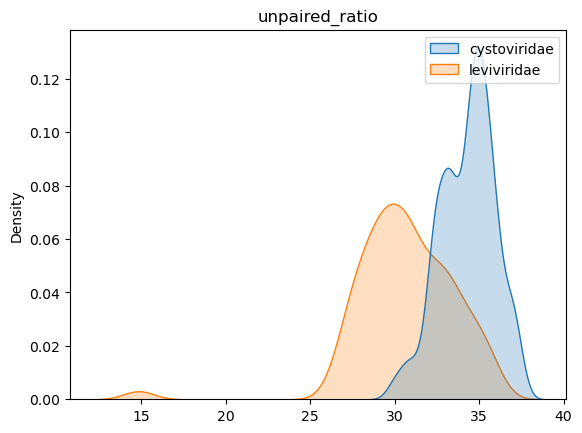

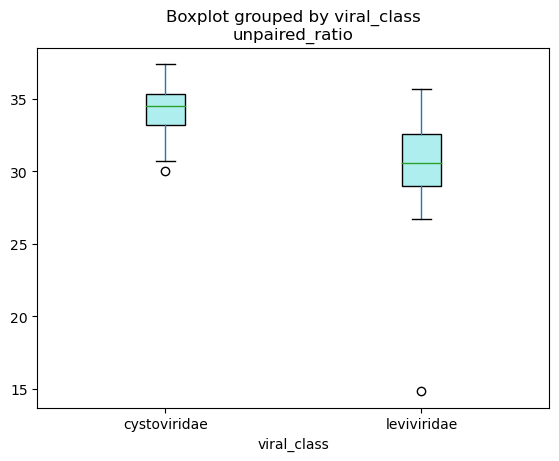

,cystoviridae,leviviridae
cystoviridae,1.000000e+00,8.028869e-15
leviviridae,8.028869e-15,1.000000e+00



Variable =  free_energy
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.13442439946465648 p_val= 0.7144262355106359
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  56.03005886160054 p_val= 7.137144312989241e-14
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is -407.012
leviviridae  median is -499.339


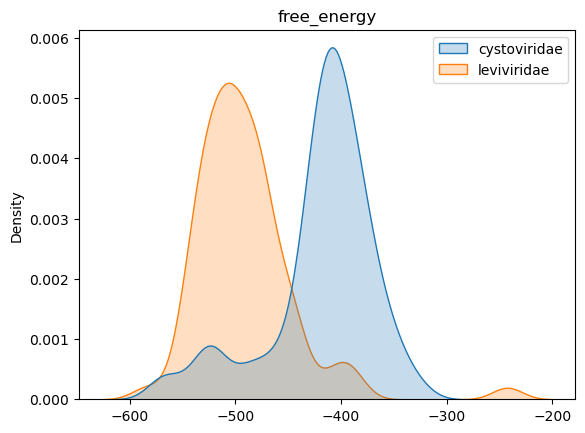

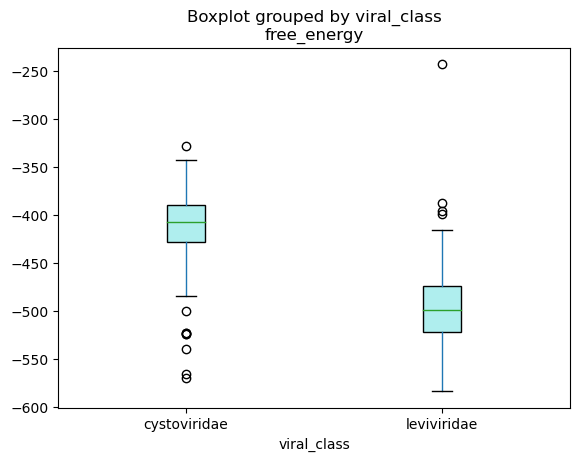

,cystoviridae,leviviridae
cystoviridae,1.000000e+00,7.137144e-14
leviviridae,7.137144e-14,1.000000e+00



Variable =  multiloops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  12.448214325699487 p_val= 0.0005618834447113729
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  13.206351265178844 p_val= 0.00027900201280391254
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 7.713
leviviridae  median is 7.225


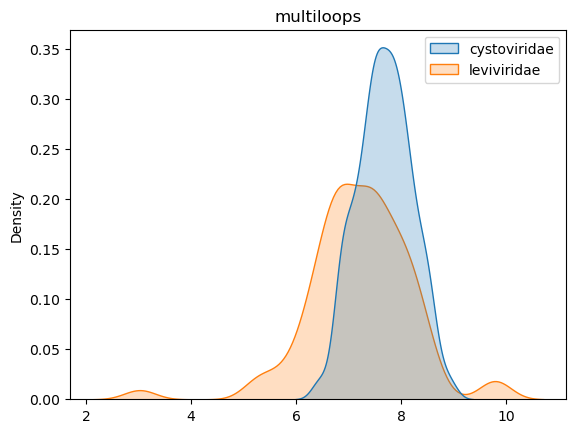

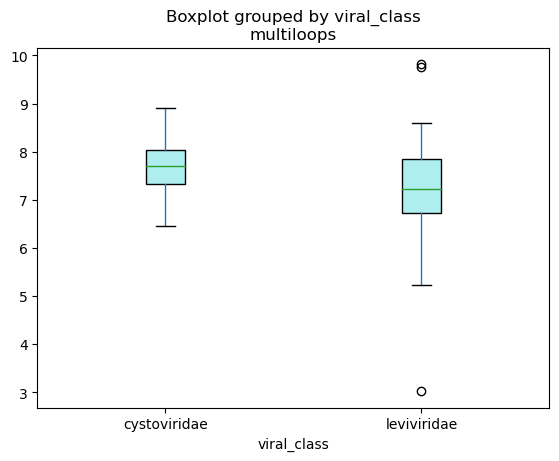

,cystoviridae,leviviridae
cystoviridae,1.000000,0.000279
leviviridae,0.000279,1.000000



Variable =  stems
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  2.2465294103896074 p_val= 0.13610351554155217
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  5.672051867083537 p_val= 0.017237282601062873
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 75.745
leviviridae  median is 76.923


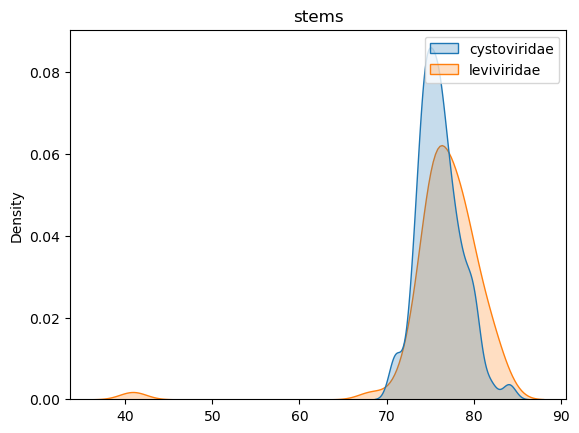

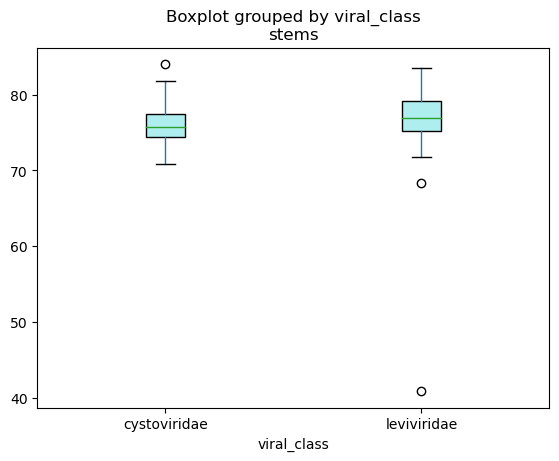

,cystoviridae,leviviridae
cystoviridae,1.000000,0.017237
leviviridae,0.017237,1.000000



Variable =  hairpins
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  18.864651362015344 p_val= 2.6322494246634708e-05
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  0.5186264647485358 p_val= 0.4714281818092483
P_val is greater than alpha=0.05, failed to reject H0 


cystoviridae  median is 20.862
leviviridae  median is 20.489


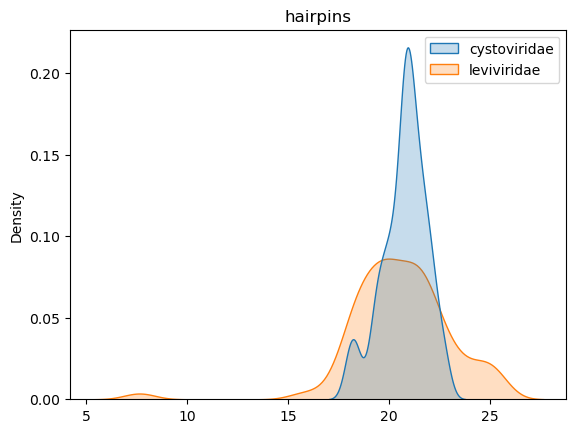

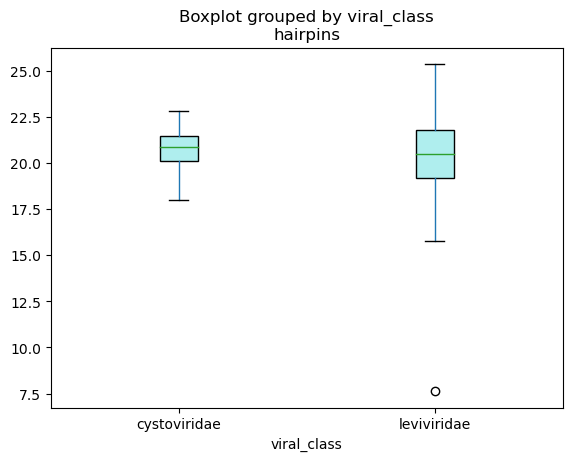

,cystoviridae,leviviridae
cystoviridae,1.000000,0.471428
leviviridae,0.471428,1.000000



Variable =  interior_loops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  11.156283061672696 p_val= 0.0010666130106935902
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  5.993393867211012 p_val= 0.014359548905670386
P_val is less than alpha=0.05, H0 is rejected


cystoviridae  median is 47.303
leviviridae  median is 49.041


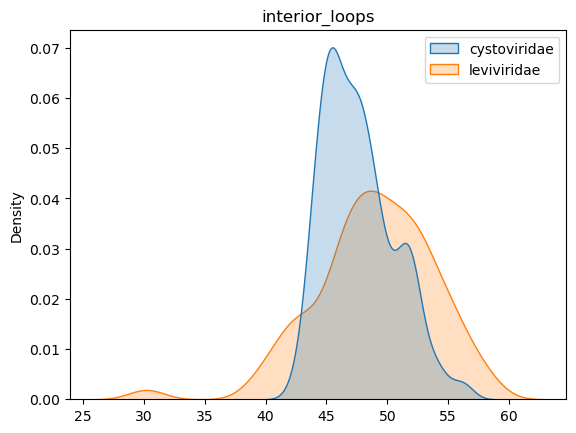

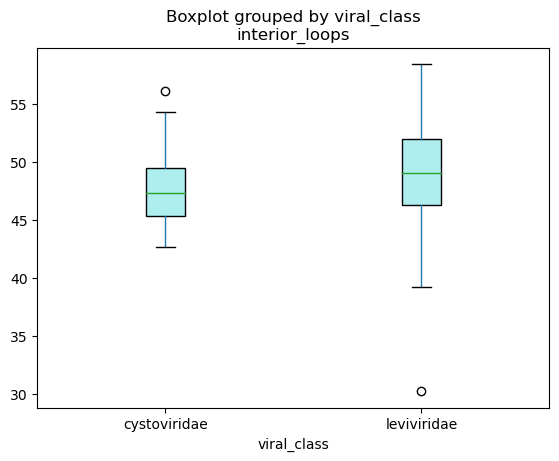

,cystoviridae,leviviridae
cystoviridae,1.00000,0.01436
leviviridae,0.01436,1.00000


In [99]:
main(cysto_path,levi_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,viral_class,name,length,free_energy,unpaired_ratio,stems,multiloops,hairpins,interior_loops
0,leviviridae,ND_003028,3911,-493.365,30.350,74.406,7.926,25.313,41.166
1,leviviridae,ND_000659,3359,-513.001,29.801,77.106,9.824,20.542,46.740
2,leviviridae,ND_003225,3933,-524.645,30.587,79.329,7.119,19.069,53.140
3,leviviridae,ND_003641,3864,-531.607,29.762,75.828,6.729,18.116,50.983
4,leviviridae,ND_000666,3217,-461.309,34.038,76.158,8.393,21.759,46.006
...,...,...,...,...,...,...,...,...,...
134,mymonaviridae,ND_178227,9479,-411.098,33.790,78.700,7.807,17.723,53.170
135,mymonaviridae,ND_032180,8489,-514.870,32.572,82.224,8.246,17.199,56.779
136,mymonaviridae,ND_031153,11044,-442.892,33.720,78.685,7.787,19.830,51.068
137,mymonaviridae,ND_204314,8901,-381.860,33.648,75.609,7.190,18.313,50.107



Variable =  unpaired_ratio
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  4.76992673009046 p_val= 0.029799764703549662
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  124.01283317976936 p_val= 8.370051054665315e-29
P_val is less than alpha=0.05, H0 is rejected


leviviridae  median is 31.179
mymonaviridae  median is 34.861


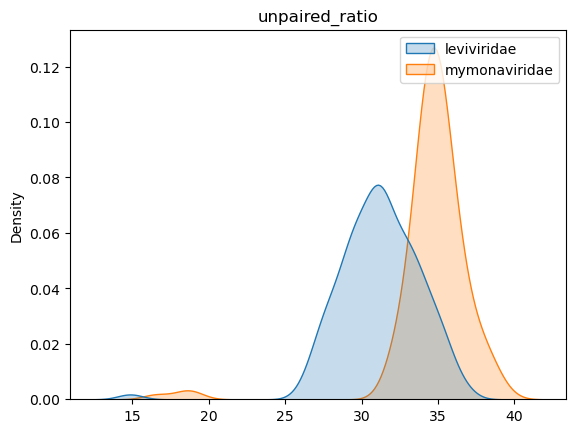

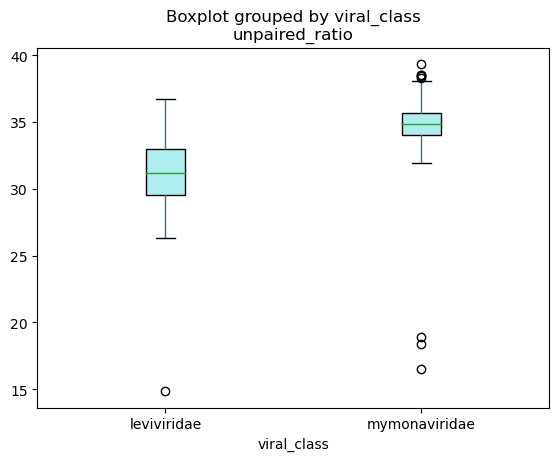

,leviviridae,mymonaviridae
leviviridae,1.000000e+00,8.370051e-29
mymonaviridae,8.370051e-29,1.000000e+00



Variable =  free_energy
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.07225615857408486 p_val= 0.7882797976641629
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  145.42334659317018 p_val= 1.735432695669802e-33
P_val is less than alpha=0.05, H0 is rejected


leviviridae  median is -491.18600000000004
mymonaviridae  median is -408.582


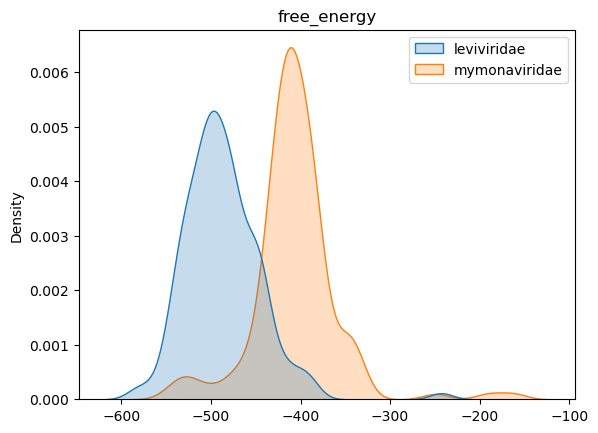

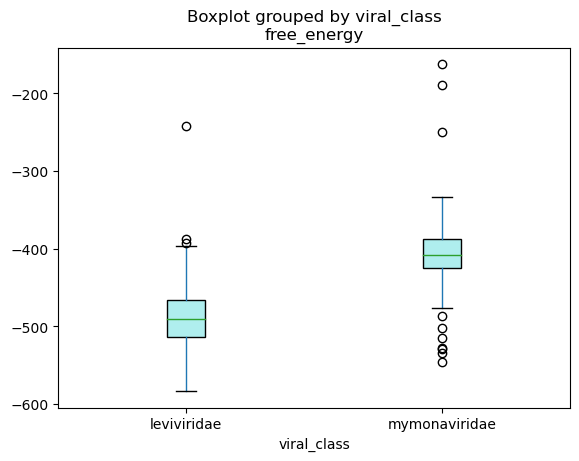

,leviviridae,mymonaviridae
leviviridae,1.000000e+00,1.735433e-33
mymonaviridae,1.735433e-33,1.000000e+00



Variable =  multiloops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  11.486955541715364 p_val= 0.0008027188279067
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  70.1298450000355 p_val= 5.55264854299508e-17
P_val is less than alpha=0.05, H0 is rejected


leviviridae  median is 7.17
mymonaviridae  median is 8.059


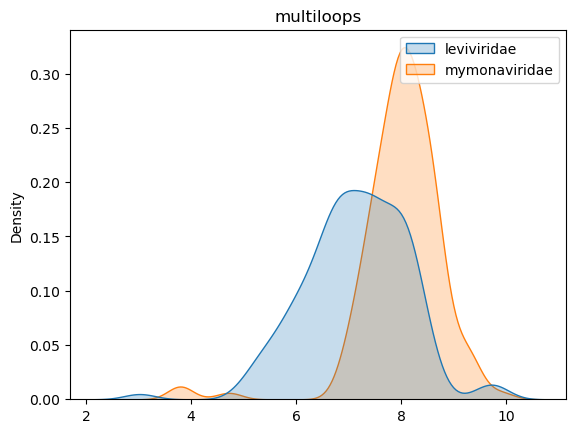

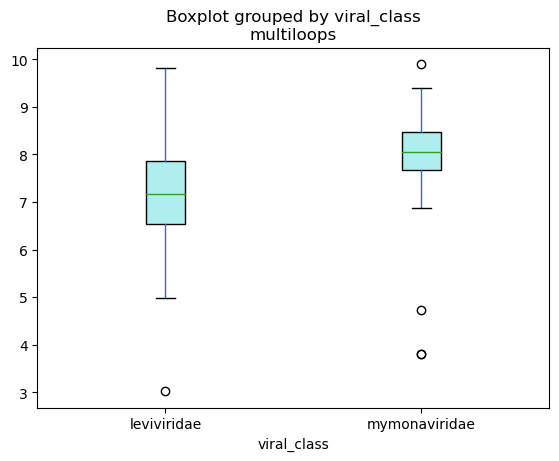

,leviviridae,mymonaviridae
leviviridae,1.000000e+00,5.552649e-17
mymonaviridae,5.552649e-17,1.000000e+00



Variable =  stems
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  0.06610449378626033 p_val= 0.7972863241812438
P_val is greater than alpha=0.05, failed to reject H0 

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  0.09758550165503962 p_val= 0.754746594442683
P_val is greater than alpha=0.05, failed to reject H0 


leviviridae  median is 76.99600000000001
mymonaviridae  median is 76.953


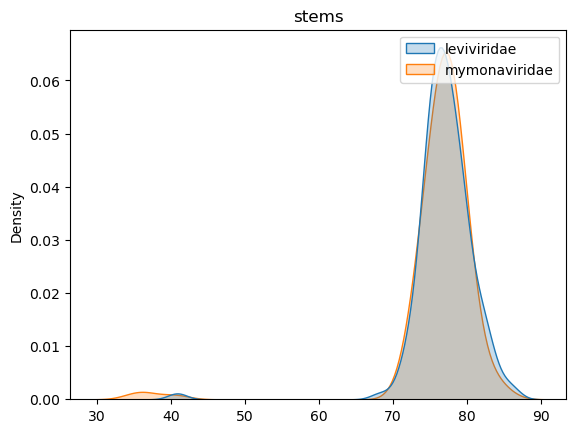

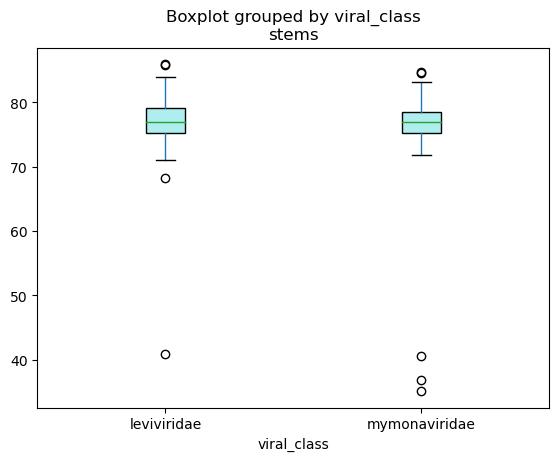

,leviviridae,mymonaviridae
leviviridae,1.000000,0.754747
mymonaviridae,0.754747,1.000000



Variable =  hairpins
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  25.04088097294383 p_val= 9.990236246263426e-07
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  44.10287871929983 p_val= 3.1156240191619155e-11
P_val is less than alpha=0.05, H0 is rejected


leviviridae  median is 20.786
mymonaviridae  median is 19.09


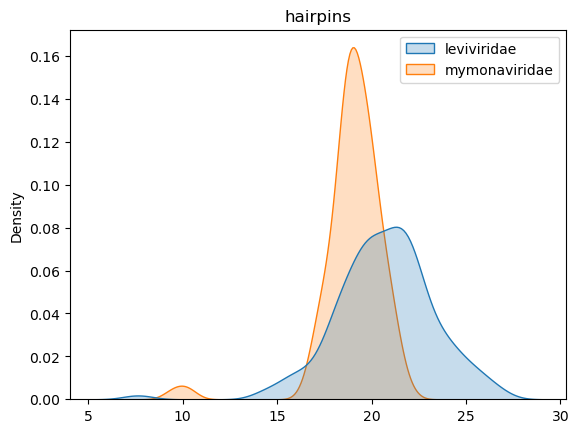

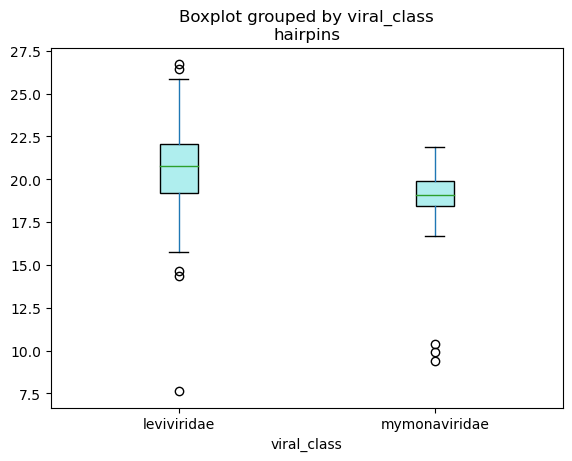

,leviviridae,mymonaviridae
leviviridae,1.000000e+00,3.115624e-11
mymonaviridae,3.115624e-11,1.000000e+00



Variable =  interior_loops
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  9.154002913027941 p_val= 0.0027149051433495264
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  2.0487322442262146 p_val= 0.15233299050348567
P_val is greater than alpha=0.05, failed to reject H0 


leviviridae  median is 49.035
mymonaviridae  median is 49.782


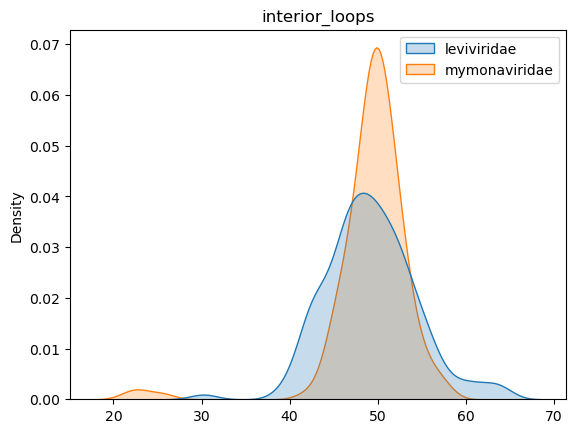

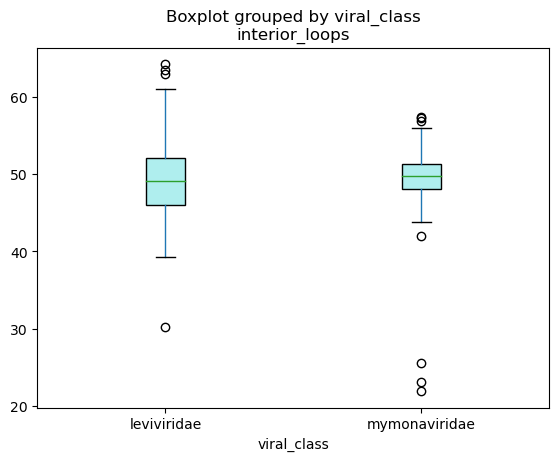

,leviviridae,mymonaviridae
leviviridae,1.000000,0.152333
mymonaviridae,0.152333,1.000000


In [102]:
main(levi_path,mymona_path, sample_size=140)

In [15]:
def kolmogorov_smirnov_test(*folders_paths,sample_size,normalize=True):
  global NUM_OF_CONTIGS 
  global NORMALIZE
  NUM_OF_CONTIGS=sample_size
  NORMALIZE = normalize
  if NORMALIZE: print("structure counts are normalized by length"\
                      ", and expressed as a ratio per 1000 bases.")  
  viral_classes_names=[]
  df_list=[]

  for folder_path in folders_paths:
    virus_type=os.path.basename(folder_path)
    viral_classes_names.append(virus_type)
    df_list.append(createDf(folder_path))
    
  stacked_df = pd.concat([df.assign(viral_class = viral_class) for df, viral_class in zip(df_list, viral_classes_names)])
  stacked_df= stacked_df.reindex(['viral_class','name','length','free_energy','unpaired_ratio','stems','multiloops','hairpins','interior_loops'], axis=1)
     
  k_smirnov_test(stacked_df, 'free_energy')
  k_smirnov_test(stacked_df, 'hairpins')
  k_smirnov_test(stacked_df, 'unpaired_ratio') 
  k_smirnov_test(stacked_df, 'multiloops') 
  k_smirnov_test(stacked_df, 'stems') 
  k_smirnov_test(stacked_df, 'interior_loops') 
    
def k_smirnov_test(stacked_df,variable):
    print('\nvariable = ',variable)
    lst = create_list_of_list_of_var(stacked_df, variable)
    rvs =lst[0]
    cdf= lst[1]
    
    alpha=0.05
    print("Kolmogorov-Smirnov test: testing the goodness of fit")
    print("H0:  samples are drawn from the same distribution \nH1:  samples aren't drawn from the same distribution")

    statistic, p_val= scipy.stats.kstest(rvs,cdf)
    print("statistic = ",statistic,"p_val=",p_val)

    rejected=(p_val<=alpha)    ## if (reject==true) then means aren't equal
    if rejected: print('P_val is less than alpha=0.05, H0 is rejected')
    else: print('P_val is greater than alpha=0.05, failed to reject H0 ')
  
    

In [16]:
kolmogorov_smirnov_test(mymona_path,cysto_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.

variable =  free_energy
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.136986301369863 p_val= 0.5028133139923099
P_val is greater than alpha=0.05, failed to reject H0 

variable =  hairpins
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.5753424657534246 p_val= 1.6615213542623107e-11
P_val is less than alpha=0.05, H0 is rejected

variable =  unpaired_ratio
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.2191780821917808 p_val= 0.059734133940186146
P_val is greater than alpha=0.05, failed to reject H0 

variable =  multiloops
Kolmogorov-

In [17]:
kolmogorov_smirnov_test(levi_path,cysto_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.

variable =  free_energy
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.7397260273972602 p_val= 1.090492624161238e-19
P_val is less than alpha=0.05, H0 is rejected

variable =  hairpins
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.2191780821917808 p_val= 0.059734133940186146
P_val is greater than alpha=0.05, failed to reject H0 

variable =  unpaired_ratio
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.6301369863013698 p_val= 6.583731112065294e-14
P_val is less than alpha=0.05, H0 is rejected

variable =  multiloops
Kolmogorov-Smirno

In [18]:
kolmogorov_smirnov_test(mymona_path,levi_path, sample_size=73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.

variable =  free_energy
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.8356164383561644 p_val= 4.1863515076931387e-26
P_val is less than alpha=0.05, H0 is rejected

variable =  hairpins
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.3972602739726027 p_val= 1.563662172337789e-05
P_val is less than alpha=0.05, H0 is rejected

variable =  unpaired_ratio
Kolmogorov-Smirnov test: testing the goodness of fit
H0:  samples are drawn from the same distribution 
H1:  samples aren't drawn from the same distribution
statistic =  0.726027397260274 p_val= 6.924628163423861e-19
P_val is less than alpha=0.05, H0 is rejected

variable =  multiloops
Kolmogorov-Smirnov test: 

In [20]:
def dist_type(folder_path,sample_size, normalize= True):
  global NUM_OF_CONTIGS
  global NORMALIZE
  NUM_OF_CONTIGS=sample_size
  NORMALIZE = normalize
  if NORMALIZE: print("structure counts are normalized by length"\
                      ", and expressed as a ratio per 1000 bases.")  
  viral_classes_names=[]
  df_list=[]


  virus_type=os.path.basename(folder_path)
  viral_classes_names.append(virus_type)
  df_list.append(createDf(folder_path))
  
  stacked_df = pd.concat([df.assign(viral_class = viral_class) for df, viral_class in zip(df_list, viral_classes_names)])
  stacked_df= stacked_df.reindex(['viral_class','name','length','free_energy','unpaired_ratio','stems','multiloops','hairpins','interior_loops'], axis=1)
  
  res_dict={ 'variable' : [],'result' : []}
  is_normal(stacked_df,'free_energy',res_dict)
  is_normal(stacked_df,'unpaired_ratio',res_dict)
  is_normal(stacked_df,'stems',res_dict)
  is_normal(stacked_df,'multiloops',res_dict)
  is_normal(stacked_df,'hairpins',res_dict)
  is_normal(stacked_df,'interior_loops',res_dict)   
  
  res_df = pd.DataFrame(res_dict)
  display(res_df)

In [21]:
def is_normal(stacked_df, variable,res_dict):
  lst_of_samples = create_list_of_list_of_var(stacked_df,variable)
  if test_normality(lst_of_samples[0]) == False:
    res_dict['variable'].append(variable)
    res_dict['result'].append('non normal')
  else: 
    res_dict['variable'].append(variable)
    res_dict['result'].append('normal')
  

In [22]:
dist_type(cysto_path,73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,variable,result
0,free_energy,non normal
1,unpaired_ratio,normal
2,stems,normal
3,multiloops,normal
4,hairpins,non normal
5,interior_loops,non normal


In [23]:
dist_type(mymona_path,73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,variable,result
0,free_energy,non normal
1,unpaired_ratio,non normal
2,stems,non normal
3,multiloops,non normal
4,hairpins,non normal
5,interior_loops,non normal


In [24]:
dist_type(levi_path,73)

structure counts are normalized by length, and expressed as a ratio per 1000 bases.


,variable,result
0,free_energy,non normal
1,unpaired_ratio,non normal
2,stems,non normal
3,multiloops,non normal
4,hairpins,non normal
5,interior_loops,non normal
